# Natural Language Processing - Part 3: Introducing transformer models to predict ratings

### Motivation

The cleaning and pre-processing will be identical. For the feature creation and the modeling, we will use the Hugging Face implementation of [transformers](https://github.com/huggingface/transformers) for Tensorflow 2.0. Transformers provides a general architecture implementation for several state of the art models in the natural language domain. We will use BERT from Google.

### Setup / Data set / cleaning / pre processing

Same preprocessing as before.

In [1]:
# Needed on Google Colab
import os
if os.environ.get('COLAB_GPU', False):
    #!pip install -U transformers
    from google.colab import drive
    drive.mount("/drive")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0
Mounted at /drive


In [2]:
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.15.0


Executing this on Colab will make sure that our model runs on a TPU if available and falls back to GPU / CPU otherwise:

In [3]:
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


First we mount google drive again to Colab, and load data.

In [4]:
# store current path and download data there
from google.colab import drive
drive.mount('/content/drive')

# For files in Google Drive
# Store the dataset in your Google drive.

dataset_path = "/content/drive/MyDrive/combined-set-2.csv"
CURR_PATH = "/content/drive/MyDrive"

Mounted at /content/drive


Let's load the data set and create our target variable. Positive ratings (one or two) will be considered as good and negative ones (five or six) as negative. As before, we ignore neutral ratings:

In [5]:
# read data from csv
data = pd.read_csv(CURR_PATH + "/combined-set-2.csv")
# Clean Text column
data = data.iloc[:, [6,3]] # 3 = 8 for selftext_clean
#print(data)
#data.head(2)
print(data.columns)
data.head(2)

Index(['is_suicide', 'selftext'], dtype='object')


,is_suicide,selftext
0,0,"Hi I don't really know how to phrase this situation but I'll try. My life is at a really good point right now, I'm never really depressed over stuff and 99 percent of the time my mind is clear. I'm about to graduate high school and I'm really excited. However, people in my family and friend group have tons of issues. Wether they sleep all day, hate themselves, or have no ambition to keep living on in this world, they've got problems. I don't wanna sound like I'm gloating, but usually I'm the person that a lot of these people end up going to because usually I'm able to talk people through issues and help them in the long run. Yeah sometimes their issues make me really sad and stuff because who doesn't feel sad when people are telling you they feel worthless.\n\nBut today one of my best friends showed me that he was cutting and it really effected me. I talked to him about it and it's mostly because of how painfully ""bored"" he is and he doesn't even know why he's doing it (he's a pretty logical guy). He will go to class and just sit there for and hour most of the time doing nothing challenging because that's the way our school works. He has clinically diagnosed depression, has been to a psychiatric ward, and sees a therapist regularly. It's only been a couple hours since he showed me his arm, and I didn't even see all of it. \n\nI've got two main problems right now. First I don't really know how to help him. He said literally the only thing I can really do is just hang out with him after school and on the weekends so he doesn't just sit in bed all day. I've been trying to make an effort to do that as much as I can but I need to do more. He said himself that as long as he goes to highschool, and considering it's the law, he's going to feel this way until we graduate. I just need to know something I can do to help him, do I tell his parents? A therapist won't help he already goes to one. Should I talk to him more about it tomorrow. I just don't know\n\nSecond, stuff like this is really effecting me. I just feel that the world is being unfair to everyone I care about and I just want everyone I love to feel better. As of lately I've been feeling depressed whenever my friends need to talk about issues and it's really weighing down on me. I just don't want to leave the people I care about down in the dirt. \n\nSo yeah if anyone has any advice whatsoever please help me. Im normally able to deal with these feelings and help my friends but right now I'm struggling. Thank you ❤️"
1,1,i have been so depressed these past couple weeks ever since i got back from vacation normal life and reality has hit me and its terrible. im 19 i havent moved out yet i dont really have a sufficient job i have one but its not enough money for me to support myself. at least i have a car and im taking online classes so. i feel stuck in this stupid fucking town. empty and alone man i just want someone to love me dude but im ugly and fat and worthless and no one is ever going to see im worth the chance. its just one thing after another to worry about. why not end it now before i really fuck up and become miserable? i dont see the point in going on im just really down right now i dont know what to do )): all there is darkness idk how to get out of this hole i hate myself i hate my body i hate my life i dont think it will ever get better


Our cleaning and pre-processing strategy will be almost identical as before. We will keep the text structure unchanged and only tidy it up a bit. The only difference to before is that we won't transform the texts to lowercase, as this is not needed for BERT transformer:


In [6]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Now, we can we apply this pre-processing and cleaning to our original data:

In [7]:
#%%time
# Clean Comments
data["selftext_clean"] = data.loc[data["selftext"].str.len() > 20, "selftext"]
data["selftext_clean"] = data["selftext_clean"].map(
    lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x
)

This is how the final comments will look like:

In [8]:
# Drop Missing
data = data.dropna(axis="index", subset=["is_suicide", "selftext_clean"]).reset_index(
    drop=True
)
data = data[["selftext_clean", "is_suicide"]]
data.columns = ["text", "label"]
data.head(2)


,text,label
0,"Hi don really know how to phrase this situation but ll try . My life is at really good point right now , never really depressed over stuff and percent of the time my mind is clear . about to graduate high school and really excited . However , people in my family and friend group have tons of issues . Wether they sleep all day , hate themselves , or have no ambition to keep living on in this world , they ve got problems . don wan na sound like gloating , but usually the person that lot of these people end up going to because usually able to talk people through issues and help them in the long run . Yeah sometimes their issues make me really sad and stuff because who doesn feel sad when people are telling you they feel worthless . But today one of my best friends showed me that he was cutting and it really effected me . talked to him about it and it mostly because of how painfully bored he is and he doesn even know why he doing it he pretty logical guy . He will go to class and just sit there for and hour most of the time doing nothing challenging because that the way our school works . He has clinically diagnosed depression , has been to psychiatric ward , and sees therapist regularly . It only been couple hours since he showed me his arm , and didn even see all of it . ve got two main problems right now . First don really know how to help him . He said literally the only thing can really do is just hang out with him after school and on the weekends so he doesn just sit in bed all day . ve been trying to make an effort to do that as much as can but need to do more . He said himself that as long as he goes to highschool , and considering it the law , he going to feel this way until we graduate . just need to know something can do to help him , do tell his parents ? therapist won help he already goes to one . Should talk to him more about it tomorrow . just don know Second , stuff like this is really effecting me . just feel that the world is being unfair to everyone care about and just want everyone love to feel better . As of lately ve been feeling depressed whenever my friends need to talk about issues and it really weighing down on me . just don want to leave the people care about down in the dirt . So yeah if anyone has any advice whatsoever please help me . Im normally able to deal with these feelings and help my friends but right now struggling . Thank you",0
1,have been so depressed these past couple weeks ever since got back from vacation normal life and reality has hit me and its terrible . im havent moved out yet dont really have sufficient job have one but its not enough money for me to support myself . at least have car and im taking online classes so . feel stuck in this stupid fucking town . empty and alone man just want someone to love me dude but im ugly and fat and worthless and no one is ever going to see im worth the chance . its just one thing after another to worry about . why not end it now before really fuck up and become miserable ? dont see the point in going on im just really down right now dont know what to do all there is darkness idk how to get out of this hole hate myself hate my body hate my life dont think it will ever get better,1


### A brief background on transformers and BERT

Transformer models, similar to RNNs (e.g. the LSTM ), are designed to handle sequences of data well. They shine at picking up relations between various inputs in an input sequence. Hence, they lend themselves perfectly for NLP tasks where such associations correspond to semantic relationships. This is also a convenient property of LSTM models, e.g. the one we implemented previously. It was able to learn relationships between sequences of the input, e.g. word vectors. For LSTMs, however, this ability is limited. Because inputs are processed in sequence, in practice, at the end of a long sentence information from the beginning will often be lost. Also, computational limits come into play really quick for the same reason. Transformer models address this issue by using the so called `attention` mechanism. This allows them to process inputs in a non sequential way which allows for better parallelization. Following, computational efficiency is greatly improved. In addition, they learn associations between words even if those are far apart in a sentence. This is an outstanding improvement when trying to model language. It explains why transformers are at the foundation of most state of the art models and why they have surpassed former architectures like LSTMs.

BERT has been developed by Google and has set new records on several language related tasks. Its main novelty is the introduction of bi-directionality. Previous models looked at inputs uni directionally, i.e. from left to right. In contrast, BERT also looks at them from right to left. The authors have proved that this leads to a deeper understanding of context in texts and increases performance significantly.  
As most other state of the art models, a lot of BERT's performance comes from sheer size. BERT large (24 layers, 16 attention heads, 340 million parameters) is trained on a huge text dataset in order to gain a thorough understanding of language in general. For this, it follows several ingenious unsupervised training strategies. Training such models is extremely computationally demanding and expensive.   
Fortunately, we can apply the principle of transfer learning to such models. That is, we can fine tune a pre trained model on a more specific task and dataset (which doesn't need to be that huge). In our case, we will simply add a classification layer to the pre trained BERT model. Then, we will do a supervised training on our labeled dataset. Consequently, we will mainly train our classifier layer while most other layers will only be minimally impacted. In a sense, we use the general language understanding of the pre trained model and improve its understanding of our unique domain. Moreover, we teach it to solve a specific task. In our case, this will be sentiment analysis in the form of a binary text classification.

### Feture Creation and Modeling

As mentioned before, we use the [`transformers`](https://github.com/huggingface/transformers) library. To stay consistent with our previous neural network model, we use the Tensorflow 2.0 implementation. In addition, this allows us to use the TPU on Google Colab without much trouble. Another invaluable advantage of the transformers library, is that several pre trained models are readily available for usage.  
BERT comes with its own Tokenizer. As with the model itself, we will use a pre trained version of the tokenizer. 



In [9]:
# this will download and initialize the pre trained tokenizer
!pip install transformers==4.37.2
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 71.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.1
    Uninstalling transformers-4.40.1:
      Successfully uninstalled transformers-4.40.1


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The inputs expected by BERT are very similar to the ones we've used before: they are just vectors containing integers which can be mapped to tokens by using a dictionary. The only difference is that BERT expects several "special" tokens. `[CLS]` stands for classification and marks the beginning of a new input to be classified. `[SEP]` marks the separation between sentences. Finally, `[PAD]` is used as a placeholder in order to pad all vectors to the same fixed length. The helper method `encode_plus` of the `Tokenizer` object deals with creating the numeric vectors while taking care of the extra tokens:



In [10]:
MAXLEN = 192

def preprocess_text(data):
    """ take texts and prepare as input features for BERT
    """
    input_ids = []
    # For every sentence...
    for comment in data:
        encoded_sent = tokenizer.encode_plus(
            text=comment,
            add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
            max_length=MAXLEN,  # Max length to truncate/pad
            pad_to_max_length=True,  # Pad sentence to max length
            return_attention_mask=False,  # attention mask not needed for our task
        )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get("input_ids"))
    return input_ids

 There is one more major difference between BERT's word embeddings and e.g. FastText's. In BERT, a word's vector representation is not static anymore but depends on context. Consequently, the vector for "broke" is different when it's in a context of "money" vs. " a record". This immensely improves contextual awareness and might benefit predictions in many cases.  
Now, we apply the tokenization process to our data:

In [12]:
#%%time

PATH_GDRIVE_TMP = "/drive/My Drive/tmp"  # Google Drive
PATH_GDRIVE_TMP = "/drive/My Drive"  # Google Drive

input_ids = preprocess_text(data["text"])


Next, we split out data into train and test for cross validation:

In [13]:
# Sample data for cross validation
train_ids, test_ids, train_labels, test_labels = train_test_split(
    input_ids, data["label"], random_state=1, test_size=0.10, shuffle=True
)
print(f"Train set: {len(train_ids)}\nTest set: {len(test_ids)}")

Train set: 1633
Test set: 182


Here, we set the model parameters. `MAXLEN` is the max. number of tokens in our input. Longer inputs will be truncated to this. While greater lengths will yield better predictions, they also mean a greater computational toll. We differentiate between `BATCH_SIZE_PER_REPLICA` and `BATCH_SIZE` when we run on multiple GPUs or TPUs, as is the case on Google Colab. Each TPU core will deal with `BATCH_SIZE_PER_REPLICA` batches at a time (= 1 when running on GPU/CPU). `EPOCHS` is simply the number of training iterations over the whole training set:

In [14]:
# Set Model Parameters
MAXLEN = MAXLEN
BATCH_SIZE_PER_REPLICA = 16
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
EPOCHS = 8
LEARNING_RATE = 1e-5
DATA_LENGTH = len(data)

As a last step before building our model, we need to prepare our dataset. Before, we used NumPy arrays as inputs. Here, we use the `tf.data.Dataset` class which offers several convenient methods:

In [15]:
def create_dataset(
    data_tuple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    buffer_size=DATA_LENGTH,
    train=False,
):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(
            buffer_size=buffer_size, reshuffle_each_iteration=True
        ).repeat(epochs)
    dataset = dataset.batch(batch_size)
    return dataset


train = create_dataset(
    (train_ids, train_labels), buffer_size=len(train_ids), train=True
)
test = create_dataset((test_ids, test_labels), buffer_size=len(test_ids))

Finally, we define a function that returns our model architecture:

In [16]:
def build_model(transformer, max_len=MAXLEN):
    """ add binary classification to pretrained model
    """
    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = tf.keras.layers.Dense(1, activation="sigmoid")(cls_token)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=out)
    model.compile(
        tf.keras.optimizers.Adam(lr=LEARNING_RATE),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In the first step, we define an `Input` layer which expects our numeric vectors as input. Then, we add the pre trained transformer which receives the inputs from the previous layer. The output of the transformer is then fed into a `Dense` layer which finally outputs a probability for our input belonging to class 0 or 1.  
Now, we build our model by first downloading the pre trained BERT and passing it to our `build_model` function:

In [17]:
with strategy.scope():
    transformer_layers = TFBertModel.from_pretrained("bert-base-cased")
    model = build_model(transformer_layers, max_len=MAXLEN)
model.summary()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 192)]             0         
 )                                                               
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   108310272 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 192, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                   

In total we have almost 110 Mio. trainable parameters. It's convenient that almost all of them have already been trained. Because we use the pre trained weights for them, they will only need to change ever so slightly. Still, it is a big model and even training on GPUs takes considerable time. So again, good thing that we can use TPUs.  
Next, we define callbacks that will be used during training. The `EartlyStopping` callback will stop the training if validation loss stops decreasing between epochs. This avoids overfitting. `ModelCheckpoint` saves checkpoints of the model after each epoch, so that training can be resumed. On Google Colab, you can currently only save TPU models in a Cloud Bucket but not on a mounted Google Drive. Hence, I commented out that part:

In [18]:
# Stop training when validation acc starts dropping
# Save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, patience=5, restore_best_weights=True
    ),
    # tf.keras.callbacks.ModelCheckpoint(
    #    PATH_GDRIVE_TMP + now + "_Model_{epoch:02d}_{val_loss:.4f}.h5",
    #    monitor="val_loss",
    #    save_best_only=True,
    #    verbose=1,
    # ),
]

Finally, time to get excited! We can now start the model training:

In [19]:
#%%time
# Train using appropriate steps per epochs (go through all train data in an epoch)
steps_per_epoch = int(np.floor((len(train_ids) / BATCH_SIZE)))
print(
    f"Model Params:\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
    f"Learning rate: {LEARNING_RATE}"
)
hist = model.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=test,
    verbose=1,
    callbacks=callbacks,
)

Model Params:
batch_size: 16
Epochs: 8
Step p. Epoch: 102
Learning rate: 1e-05
Epoch 1/8


102/102 [==============================] - 116s 691ms/step - loss: 1.1331 - accuracy: 0.4847 - val_loss: 0.6985 - val_accuracy: 0.4835
Epoch 2/8
102/102 [==============================] - 68s 666ms/step - loss: 0.7195 - accuracy: 0.4963 - val_loss: 0.7325 - val_accuracy: 0.4835
Epoch 3/8
102/102 [==============================] - 68s 668ms/step - loss: 0.7162 - accuracy: 0.5031 - val_loss: 0.7088 - val_accuracy: 0.5165
Epoch 4/8
102/102 [==============================] - 68s 669ms/step - loss: 0.7312 - accuracy: 0.4957 - val_loss: 0.6933 - val_accuracy: 0.4835
Epoch 5/8
102/102 [==============================] - 68s 670ms/step - loss: 0.7162 - accuracy: 0.4920 - val_loss: 0.6927 - val_accuracy: 0.5165
Epoch 6/8
102/102 [==============================] - 68s 667ms/step - loss: 0.7109 - accuracy: 0.5178 - val_loss: 0.6943 - val_accuracy: 0.4835
Epoch 7/8
102/102 [==============================] - 68s 667ms/step - loss: 0.7049 - accuracy: 0.4896 - val_loss: 0.6961 - val_accuracy: 0.5165
E

The model converges really fast and stops early after only three epochs. This is because it already achieves the lowest validation loss in the second period:

Since the low loss value indicates that our model is already really good, we don't do any hyperparameter tuning. Also, our parameters were already chosen with good care. However, when looking for peak performance, it would be reasonable to compare different configurations. Natural starting points would be to:
1. Increasing the input length
2. Change the learning rate or use a dynamic rate adaption
3. Try different batch sizes

I'd expect to see some further but very marginal improvement from these steps.

[Text(0.5, 1.0, 'Model loss'),
 Text(0, 0.5, ''),
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8')]]

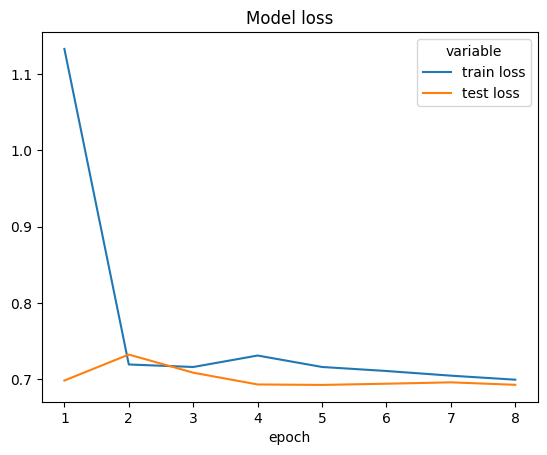

In [20]:
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss",
    ylabel="",
    xticks=range(1, loss["epoch"].max() + 1),
    xticklabels=loss["epoch"].unique(),
)

### Evaluation

Was this all worth it? Let's find out:

In [21]:
# predict on test set
pred = model.predict(test, batch_size=BATCH_SIZE, verbose=2, use_multiprocessing=True)

12/12 - 6s - 6s/epoch - 518ms/step


In [22]:
# Load best model from Checkpoint
# model = load_model(PATH_GDRIVE_TMP+"BERT.h5", compile=False)
pred_class = (pred > 0.5).astype(int)
report = metrics.classification_report(test_labels, pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.52      1.00      0.68        94
           1       0.00      0.00      0.00        88

    accuracy                           0.52       182
   macro avg       0.26      0.50      0.34       182
weighted avg       0.27      0.52      0.35       182



### Conclusion

We have introduced the transformer architecture and more specifically the BERT model. Using the HuggingFace `transformers` library for Python, we have fine tuned a pre trained English language BERT model. For that training, we have used a free Google Colab instance with a TPU.